In [1]:
import pandas as pd

import os

os.environ["OMP_NUM_THREADS"] = "2"
os.environ["OPENBLAS_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"



import pandas as pd

# Load and combine datasets (as before)
datasets = {
    'benign': pd.read_csv('labeled_dataset_benign.csv'),
    'dns': pd.read_csv('labeled_dataset_DNS_Spoofing.csv'),
    'mitm': pd.read_csv('labeled_dataset_MITM_ArpSpoofing.csv')
}
combined_df = pd.concat([datasets['benign'], datasets['dns'], datasets['mitm']], ignore_index=True)
combined_df = combined_df.drop('dst_mac', axis=1)

print(combined_df.shape)

C:\Users\nazih\AppData\Local\Temp\ipykernel_13584\1938280762.py:18: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  'dns': pd.read_csv('labeled_dataset_DNS_Spoofing.csv'),
C:\Users\nazih\AppData\Local\Temp\ipykernel_13584\1938280762.py:19: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  'mitm': pd.read_csv('labeled_dataset_MITM_ArpSpoofing.csv')


(883525, 135)


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

def is_hex_mac(mac):
    if pd.isna(mac) or mac == 'unknown':
        return False
    pattern = r'^([0-9A-Fa-f]{2}[:-]){5}([0-9A-Fa-f]{2})$'
    return bool(re.match(pattern, str(mac)))


combined_df = combined_df[~combined_df['src_mac'].apply(is_hex_mac)]

# Drop duplicates
print(f"Number of duplicate rows: {combined_df.duplicated().sum()}")
combined_df = combined_df.drop_duplicates()
print(f"New shape after removing duplicates: {combined_df.shape}")

# Identify categorical columns
categorical_cols = [col for col in combined_df.columns if combined_df[col].nunique() < 10 or combined_df[col].dtype == 'object']
print(f"Categorical features: {categorical_cols}")

for col in categorical_cols:
    combined_df[col] = combined_df[col].astype(str).fillna('unknown')

numerical_cols = combined_df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    combined_df[col] = combined_df[col].fillna(combined_df[col].median())

X = combined_df.drop(['Label', 'src_mac'], axis=1, errors='ignore')
y_attack = combined_df['Label']
y_device = combined_df['src_mac']

# Encode device labels
le_device = LabelEncoder()
y_device_encoded = le_device.fit_transform(y_device)

from sklearn.preprocessing import MultiLabelBinarizer


combined_df['All_Labels'] = combined_df.apply(
    lambda row: [row['Label'], row['src_mac']], axis=1
)

mlb = MultiLabelBinarizer()
Y_multilabel = mlb.fit_transform(combined_df['All_Labels'])

multilabel_class_names = mlb.classes_


X_numeric = X.select_dtypes(include=['number'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)




X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled,
    Y_multilabel,
    test_size=0.2,
    random_state=42
)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)



Number of duplicate rows: 0
New shape after removing duplicates: (432555, 135)
Categorical features: ['src_mac', 'src_ip', 'dst_ip', 'port_class_dst', 'l4_tcp', 'l4_udp', 'ttl', 'handshake_version', 'handshake_ciphersuites', 'tls_server', 'http_request_method', 'http_host', 'http_response_code', 'user_agent', 'dns_server', 'dns_query_type', 'dns_len_ans', 'device_mac', 'eth_src_oui', 'eth_dst_oui', 'highest_layer', 'http_uri', 'http_content_len', 'http_content_type', 'icmp_type', 'icmp_checksum_status', 'icmp_data_size', 'Label']


C:\Users\nazih\AppData\Local\Temp\ipykernel_13584\1952102281.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['All_Labels'] = combined_df.apply(


In [34]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss
from sklearn.model_selection import KFold
from sklearn.base import clone

# =========================================================================
# 0. CONFIGURATION AND ASSUMPTIONS
# =========================================================================

# NOTE: X_train and Y_train must be defined before running.
# X_train should be a pandas DataFrame for RFE feature selection.
# Y_train should be a NumPy array of shape [n_samples, num_outputs].

N_SPLITS = 5
TARGET_FEATURES = 15
KF = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# --- Base Estimator Definitions ---
xgb_rfe_estimator = XGBClassifier(
    n_estimators=100,
    random_state=42,
    eval_metric='logloss'
)

xgb_base = XGBClassifier(
    n_estimators=100, learning_rate=0.1, random_state=42, 
    eval_metric='logloss',  reg_alpha=0.5, 
    reg_lambda=3
)

# =========================================================================
# 1. RFE FEATURE SELECTION
# =========================================================================

rfe_selector = RFE(
    estimator=xgb_rfe_estimator,
    n_features_to_select=TARGET_FEATURES,
    step=5,
    verbose=1
)

print(f"Starting RFE to select {TARGET_FEATURES} features...")
Y_single_label = Y_train[:, 0]
rfe_selector.fit(X_train, Y_single_label)

selected_features = X_train.columns[rfe_selector.support_]
X_RFE = X_train[selected_features] # Full RFE features for CV and final fit
Y_RFE = Y_train 

print(f"RFE complete. Using {len(selected_features)} features.")
print(f"Selected features: {selected_features.tolist()[:5]}... (first 5 shown)")

# Determine label names for reporting
try:
    multilabel_class_names = mlb.classes_
except NameError:
    multilabel_class_names = [f"Label_{i+1}" for i in range(Y_RFE.shape[1])]

num_outputs = Y_RFE.shape[1]
cv_metrics = {'subset_acc': [], 'jaccard': [], 'hamming_loss': []}

# =========================================================================
# 2. K-FOLD CROSS-VALIDATION LOOP (For CV Results)
# =========================================================================

print(f"\n--- Starting {N_SPLITS}-Fold CV for Weighted XGBoost on RFE Features ---")

for fold, (train_index, val_index) in enumerate(KF.split(X_RFE)):
    print(f"\n--- FITTING FOLD {fold + 1}/{N_SPLITS} ---")
    
    # Split data for the current fold
    X_train_fold, X_val_fold = X_RFE.iloc[train_index], X_RFE.iloc[val_index]
    Y_train_fold, Y_val_fold = Y_RFE[train_index], Y_RFE[val_index]
    
    fitted_xgb_estimators_fold = []
    
    # Train 61 individual models for the current fold
    for i in range(num_outputs):
        y_col = Y_train_fold[:, i]

        # Calculate scale_pos_weight based on the current fold's training data
        pos_count = np.sum(y_col == 1)
        neg_count = np.sum(y_col == 0)
        weight = neg_count / pos_count if pos_count > 0 else 1.0

        # Clone and set the specific weight for this label/fold combination
        xgb_estimator = clone(xgb_base).set_params(scale_pos_weight=weight)

        xgb_estimator.fit(X_train_fold, y_col)
        fitted_xgb_estimators_fold.append(xgb_estimator)
        
    # Prediction and Evaluation for the current validation fold
    Y_pred_fold = np.zeros_like(Y_val_fold)
    for i, estimator in enumerate(fitted_xgb_estimators_fold):
        Y_pred_fold[:, i] = estimator.predict(X_val_fold)
        
    subset_acc = accuracy_score(Y_val_fold, Y_pred_fold)
    jaccard = jaccard_score(Y_val_fold, Y_pred_fold, average='samples', zero_division=0)
    h_loss = hamming_loss(Y_val_fold, Y_pred_fold)
    
    cv_metrics['subset_acc'].append(subset_acc)
    cv_metrics['jaccard'].append(jaccard)
    cv_metrics['hamming_loss'].append(h_loss)
    
    print(f"  Fold {fold+1} Metrics | Subset Acc: {subset_acc:.4f} | Jaccard: {jaccard:.4f}")

# =========================================================================
# 3. TRAIN FINAL MODEL ON FULL DATASET (Creates fitted_xgb_estimators)
# =========================================================================

fitted_xgb_estimators = [] 
print("\n--- Training FINAL 61 XGBoost Models on FULL RFE Dataset ---")

for i in range(num_outputs):
    y_col = Y_RFE[:, i] # Use the full target data

    # Calculate scale_pos_weight based on the full Y_RFE data
    pos_count = np.sum(y_col == 1)
    neg_count = np.sum(y_col == 0)
    weight = neg_count / pos_count if pos_count > 0 else 1.0

    # Clone the base estimator and set the weight
    xgb_estimator = clone(xgb_base).set_params(scale_pos_weight=weight)

    # Fit on the full X_RFE data
    xgb_estimator.fit(X_RFE, y_col) 
    
    # Store the final fitted estimator
    fitted_xgb_estimators.append(xgb_estimator)

print(f"Successfully created fitted_xgb_estimators list with {len(fitted_xgb_estimators)} models.")

# =========================================================================
# 4. FINAL CV RESULT STORAGE (Using the metrics collected in step 2)
# =========================================================================

# Calculate and store the final CV results
xgb_cv_results = {
    'Subset Acc Mean': np.mean(cv_metrics['subset_acc']),
    'Subset Acc Std': np.std(cv_metrics['subset_acc']),
    'Jaccard Mean': np.mean(cv_metrics['jaccard']),
    'Jaccard Std': np.std(cv_metrics['jaccard']),
    'Hamming Loss Mean': np.mean(cv_metrics['hamming_loss'])
}

print("\n" + "="*70)
print("FINAL XGBOOST CROSS-VALIDATION SUMMARY")
print("="*70)
print(f"Subset Accuracy (Mean): {xgb_cv_results['Subset Acc Mean']:.2f} (+/- {xgb_cv_results['Subset Acc Std']:.4f})")
print(f"Jaccard Score (Mean): {xgb_cv_results['Jaccard Mean']:.2f} (+/- {xgb_cv_results['Jaccard Std']:.4f})")
print(f"Hamming Loss (Mean): {xgb_cv_results['Hamming Loss Mean']:.2f}")

Starting RFE to select 15 features...
Fitting estimator with 107 features.
Fitting estimator with 102 features.
Fitting estimator with 97 features.
Fitting estimator with 92 features.
Fitting estimator with 87 features.
Fitting estimator with 82 features.
Fitting estimator with 77 features.
Fitting estimator with 72 features.
Fitting estimator with 67 features.
Fitting estimator with 62 features.
Fitting estimator with 57 features.
Fitting estimator with 52 features.
Fitting estimator with 47 features.
Fitting estimator with 42 features.
Fitting estimator with 37 features.
Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.
Fitting estimator with 17 features.
RFE complete. Using 15 features.
Selected features: [2, 6, 7, 53, 61]... (first 5 shown)

--- Starting 5-Fold CV for Weighted XGBoost on RFE Features ---

--- FITTING FOLD 1/5 ---
  Fold 1 Metrics | Subset Acc: 0.9056 | Jaccard: 0.9479

--- FITTING FOLD 2/5 ---
  Fold 2 Metri

In [14]:
X_test_RFE = X_test[selected_features]


In [15]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold # 👈 New Import
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss # Assuming these are imported

# --- Configuration ---
MODEL_NAME = 'RandomForest'
N_SPLITS = 5
KF = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Use the RFE-selected data for CV (Assuming X_train_RFE and Y_train are defined)
X_data_cv = X_RFE
Y_data_cv = Y_train

# --- Base Estimator ---
rf_base_estimator = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    class_weight='balanced',
    n_jobs=1
)

cv_metrics = {'subset_acc': [], 'jaccard': [], 'hamming_loss': []}

print(f"\n--- Starting {N_SPLITS}-Fold CV for {MODEL_NAME} ---")

# =========================================================================
# K-FOLD CROSS-VALIDATION LOOP
# =========================================================================
for fold, (train_index, val_index) in enumerate(KF.split(X_data_cv)):
    print(f"\n--- FITTING FOLD {fold + 1}/{N_SPLITS} ---")
    
    # 1. Split data for the current fold
    # Use .iloc for X_data_cv if it's a DataFrame; use array slicing if it's a NumPy array
    try:
        X_train_fold, X_val_fold = X_data_cv.iloc[train_index], X_data_cv.iloc[val_index]
    except AttributeError:
        # Fallback for NumPy array
        X_train_fold, X_val_fold = X_data_cv[train_index], X_data_cv[val_index]

    Y_train_fold, Y_val_fold = Y_data_cv[train_index], Y_data_cv[val_index]
    
    # 2. Configure and Fit the Multi-Output Model
    multi_model_rf_fold = MultiOutputClassifier(rf_base_estimator, n_jobs=-1)
    multi_model_rf_fold.fit(X_train_fold, Y_train_fold)
    
    # 3. Predict on the validation fold
    Y_pred_fold = multi_model_rf_fold.predict(X_val_fold)
    
    # 4. Evaluation for the current validation fold
    subset_acc = accuracy_score(Y_val_fold, Y_pred_fold)
    jaccard = jaccard_score(Y_val_fold, Y_pred_fold, average='samples', zero_division=0)
    h_loss = hamming_loss(Y_val_fold, Y_pred_fold)
    
    cv_metrics['subset_acc'].append(subset_acc)
    cv_metrics['jaccard'].append(jaccard)
    cv_metrics['hamming_loss'].append(h_loss)
    
    print(f"  Fold {fold+1} Metrics | Subset Acc: {subset_acc:.4f} | Jaccard: {jaccard:.4f}")

# =========================================================================
# FINAL CV RESULT STORAGE AND PRINTING
# =========================================================================

# Calculate mean and standard deviation for final results
rf_cv_results = {
    'Subset Acc Mean': np.mean(cv_metrics['subset_acc']),
    'Subset Acc Std': np.std(cv_metrics['subset_acc']),
    'Jaccard Mean': np.mean(cv_metrics['jaccard']),
    'Jaccard Std': np.std(cv_metrics['jaccard']),
    'Hamming Loss Mean': np.mean(cv_metrics['hamming_loss'])
}

print("\n" + "="*70)
print(f"FINAL {MODEL_NAME} CROSS-VALIDATION SUMMARY")
print("="*70)
print(f"Subset Accuracy (Mean): {rf_cv_results['Subset Acc Mean']:.4f} (+/- {rf_cv_results['Subset Acc Std']:.4f})")
print(f"Jaccard Score (Mean): {rf_cv_results['Jaccard Mean']:.4f} (+/- {rf_cv_results['Jaccard Std']:.4f})")
print(f"Hamming Loss (Mean): {rf_cv_results['Hamming Loss Mean']:.4f}")


--- Starting 5-Fold CV for RandomForest ---

--- FITTING FOLD 1/5 ---
  Fold 1 Metrics | Subset Acc: 0.9602 | Jaccard: 0.9783

--- FITTING FOLD 2/5 ---
  Fold 2 Metrics | Subset Acc: 0.9606 | Jaccard: 0.9784

--- FITTING FOLD 3/5 ---
  Fold 3 Metrics | Subset Acc: 0.9598 | Jaccard: 0.9780

--- FITTING FOLD 4/5 ---
  Fold 4 Metrics | Subset Acc: 0.9593 | Jaccard: 0.9777

--- FITTING FOLD 5/5 ---
  Fold 5 Metrics | Subset Acc: 0.9578 | Jaccard: 0.9769

FINAL RandomForest CROSS-VALIDATION SUMMARY
Subset Accuracy (Mean): 0.9595 (+/- 0.0010)
Jaccard Score (Mean): 0.9778 (+/- 0.0005)
Hamming Loss (Mean): 0.0008


In [33]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold # 👈 New Import
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss # Assuming these are imported

# --- Configuration ---
MODEL_NAME = 'DecisionTree'
N_SPLITS = 5
KF = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Use the RFE-selected data for CV (Assuming X_train_RFE and Y_train are defined)
X_data_cv = X_RFE
Y_data_cv = Y_train

# --- Base Estimator ---
dt_base_estimator = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced' # Handles imbalance internally
)

cv_metrics = {'subset_acc': [], 'jaccard': [], 'hamming_loss': []}

print(f"\n--- Starting {N_SPLITS}-Fold CV for {MODEL_NAME} ---")

# =========================================================================
# K-FOLD CROSS-VALIDATION LOOP
# =========================================================================
for fold, (train_index, val_index) in enumerate(KF.split(X_data_cv)):
    print(f"\n--- FITTING FOLD {fold + 1}/{N_SPLITS} ---")
    
    # 1. Split data for the current fold
    # Use .iloc for X_data_cv if it's a DataFrame; use array slicing if it's a NumPy array
    try:
        X_train_fold, X_val_fold = X_data_cv.iloc[train_index], X_data_cv.iloc[val_index]
    except AttributeError:
        # Fallback for NumPy array
        X_train_fold, X_val_fold = X_data_cv[train_index], X_data_cv[val_index]

    Y_train_fold, Y_val_fold = Y_data_cv[train_index], Y_data_cv[val_index]
    
    # 2. Configure and Fit the Multi-Output Model
    # Note: DecisionTree n_jobs is ignored, so we rely on MultiOutputClassifier's n_jobs=-1
    multi_model_dt_fold = MultiOutputClassifier(dt_base_estimator, n_jobs=-1)
    multi_model_dt_fold.fit(X_train_fold, Y_train_fold)
    
    # 3. Predict on the validation fold
    Y_pred_fold = multi_model_dt_fold.predict(X_val_fold)
    
    # 4. Evaluation for the current validation fold
    subset_acc = accuracy_score(Y_val_fold, Y_pred_fold)
    jaccard = jaccard_score(Y_val_fold, Y_pred_fold, average='samples', zero_division=0)
    h_loss = hamming_loss(Y_val_fold, Y_pred_fold)
    
    cv_metrics['subset_acc'].append(subset_acc)
    cv_metrics['jaccard'].append(jaccard)
    cv_metrics['hamming_loss'].append(h_loss)
    
    print(f"  Fold {fold+1} Metrics | Subset Acc: {subset_acc:.4f} | Jaccard: {jaccard:.4f}")

# =========================================================================
# FINAL CV RESULT STORAGE AND PRINTING
# =========================================================================

# Calculate mean and standard deviation for final results
dt_cv_results = {
    'Subset Acc Mean': np.mean(cv_metrics['subset_acc']),
    'Subset Acc Std': np.std(cv_metrics['subset_acc']),
    'Jaccard Mean': np.mean(cv_metrics['jaccard']),
    'Jaccard Std': np.std(cv_metrics['jaccard']),
    'Hamming Loss Mean': np.mean(cv_metrics['hamming_loss'])
}

print("\n" + "="*70)
print(f"FINAL {MODEL_NAME} CROSS-VALIDATION SUMMARY")
print("="*70)
print(f"Subset Accuracy (Mean): {dt_cv_results['Subset Acc Mean']:.4f} (+/- {dt_cv_results['Subset Acc Std']:.4f})")
print(f"Jaccard Score (Mean): {dt_cv_results['Jaccard Mean']:.4f} (+/- {dt_cv_results['Jaccard Std']:.4f})")
print(f"Hamming Loss (Mean): {dt_cv_results['Hamming Loss Mean']:.4f}")


--- Starting 5-Fold CV for DecisionTree ---

--- FITTING FOLD 1/5 ---
  Fold 1 Metrics | Subset Acc: 0.9409 | Jaccard: 0.9665

--- FITTING FOLD 2/5 ---
  Fold 2 Metrics | Subset Acc: 0.9406 | Jaccard: 0.9662

--- FITTING FOLD 3/5 ---
  Fold 3 Metrics | Subset Acc: 0.9424 | Jaccard: 0.9670

--- FITTING FOLD 4/5 ---
  Fold 4 Metrics | Subset Acc: 0.9403 | Jaccard: 0.9660

--- FITTING FOLD 5/5 ---
  Fold 5 Metrics | Subset Acc: 0.9411 | Jaccard: 0.9662

FINAL DecisionTree CROSS-VALIDATION SUMMARY
Subset Accuracy (Mean): 0.9411 (+/- 0.0007)
Jaccard Score (Mean): 0.9664 (+/- 0.0003)
Hamming Loss (Mean): 0.0016


In [20]:
from sklearn.linear_model import LogisticRegression

MODEL_NAME = 'LogisticRegression'
lr_base_estimator = LogisticRegression(
    solver='saga',
    max_iter=100,
    random_state=42,
    class_weight='balanced',       # Handles imbalance internally
    n_jobs=1
)

print(f"\n--- Training {MODEL_NAME} (Parallel Fit via MultiOutputClassifier) ---")

multi_model = MultiOutputClassifier(lr_base_estimator)

multi_model.fit(X_RFE, Y_train)

Y_pred = multi_model.predict(X_test_RFE)

subset_acc = accuracy_score(Y_test, Y_pred)
jaccard = jaccard_score(Y_test, Y_pred, average='samples', zero_division=0)

print(f"\n--- {MODEL_NAME} RESULTS ---")
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print(f"Jaccard Score (Label Similarity): {jaccard:.4f}")



--- Training LogisticRegression (Parallel Fit via MultiOutputClassifier) ---


c:\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the co


--- LogisticRegression RESULTS ---
Subset Accuracy (Exact Match): 0.3463
Jaccard Score (Label Similarity): 0.4823


In [21]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.base import clone

MODEL_NAME = 'LinearSVC'
svc_base_estimator = LinearSVC(
    random_state=42,
    class_weight='balanced',
    multi_class='ovr'
)

print(f"\n--- Training {MODEL_NAME} (Parallel Fit via MultiOutputClassifier) ---")

multi_model = MultiOutputClassifier(svc_base_estimator, n_jobs=-1)

multi_model.fit(X_RFE, Y_train)

Y_pred = multi_model.predict(X_test_RFE)

subset_acc = accuracy_score(Y_test, Y_pred)
jaccard = jaccard_score(Y_test, Y_pred, average='samples', zero_division=0)

print(f"\n--- {MODEL_NAME} RESULTS ---")
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print(f"Jaccard Score (Label Similarity): {jaccard:.4f}")




--- Training LinearSVC (Parallel Fit via MultiOutputClassifier) ---

--- LinearSVC RESULTS ---
Subset Accuracy (Exact Match): 0.3607
Jaccard Score (Label Similarity): 0.5278


Image successfully saved to: accuracies_line_chart.png


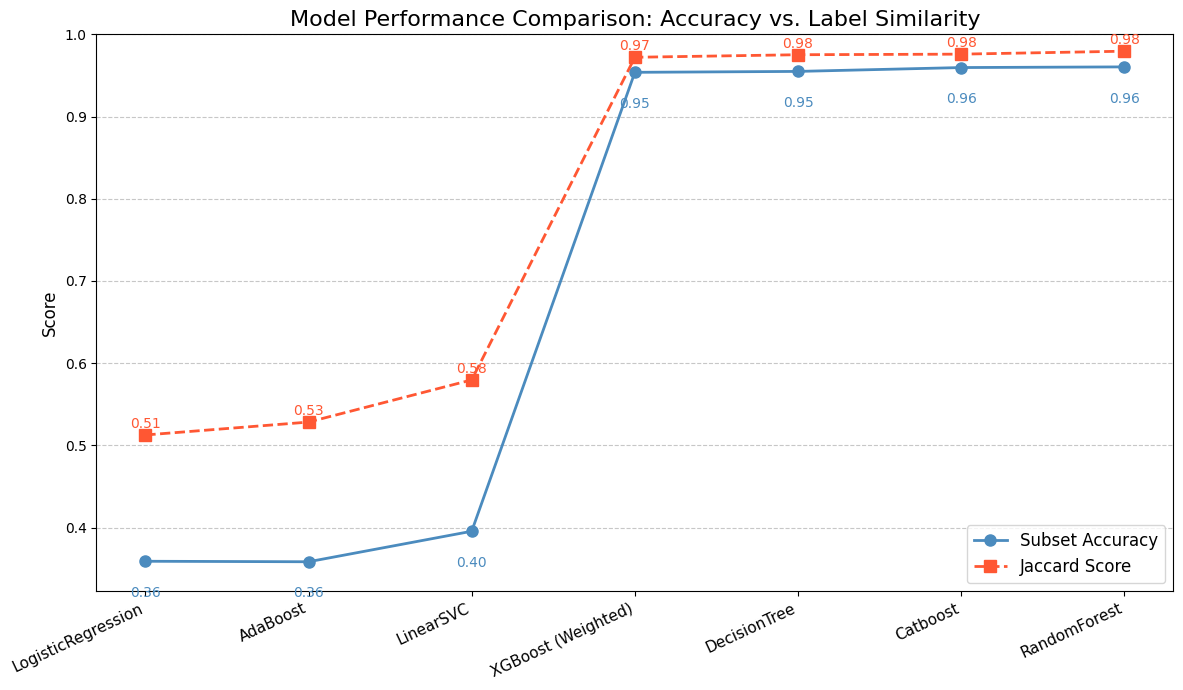

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data provided by the user
results_data = {
    'Model': [
        'LogisticRegression',
        'AdaBoost',
        'LinearSVC',
        'XGBoost (Weighted)',
        'DecisionTree',
        'Catboost',
        'RandomForest'  
    ],
    'Subset Accuracy': [ 0.3591, 0.3585, 0.3956, 0.9538, 0.9549, 0.9596, 0.9604],
    'Jaccard Score': [0.5127, 0.5284, 0.5797, 0.9721, 0.9752, 0.9759, 0.9795 ]
}

df_comparison = pd.DataFrame(results_data).set_index('Model')


def plot_accuracy_comparison(df):
    
    metrics = ['Subset Accuracy', 'Jaccard Score']
    x_labels = df.index
    x = np.arange(len(x_labels))

    fig, ax = plt.subplots(figsize=(12, 7))

    
    ax.plot(
        x, 
        df[metrics[0]], 
        label=metrics[0], 
        marker='o', 
        linestyle='-',
        linewidth=2,
        markersize=8,
        color='#4B8BBE'
    )
    
 
    ax.plot(
        x, 
        df[metrics[1]], 
        label=metrics[1], 
        marker='s', 
        linestyle='--', 
        linewidth=2,
        markersize=8,
        color='#FF5733' 
    )

    for i, model in enumerate(x_labels):
        ax.text(
            x[i], df['Subset Accuracy'].iloc[i] - 0.03, 
            f"{df['Subset Accuracy'].iloc[i]:.2f}",
            ha='center', va='top', fontsize=10, color='#4B8BBE'
        )
        ax.text(
            x[i], df['Jaccard Score'].iloc[i] + 0.005, 
            f"{df['Jaccard Score'].iloc[i]:.2f}",
            ha='center', va='bottom', fontsize=10, color='#FF5733'
        )

    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Model Performance Comparison: Accuracy vs. Label Similarity', fontsize=16)
    
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=25, ha="right", fontsize=11)
    
    ax.legend(loc='lower right', fontsize=12)
    
    min_score = df[metrics].min().min()
    ax.set_ylim(min_score * 0.9, 1.0)
    
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # --- FIX: Move plt.savefig() BEFORE plt.show() ---
    file_name = "accuracies_line_chart.png"
    plt.savefig(file_name, dpi=300)
    print(f"Image successfully saved to: {file_name}")
    
    plt.show()

plot_accuracy_comparison(df_comparison)

In [18]:
import numpy as np
import pandas as pd
import catboost as cb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold # 👈 New Import
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss # Assuming these are imported


# --- Configuration ---
MODEL_NAME = 'CatBoost'
N_SPLITS = 5
KF = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Use the RFE-selected data for CV (Assuming X_train_RFE and Y_train are defined)
X_data_cv = X_RFE
Y_data_cv = Y_train

# --- Base Estimator (CatBoost) ---
cb_base_estimator = cb.CatBoostClassifier(
    iterations=100,
    random_state=42,
    auto_class_weights='Balanced',  # Handles imbalance internally
    loss_function='Logloss',
    verbose=0,                      # Suppress output during CV
    allow_writing_files=False       # Prevent writing temporary files
)

cv_metrics = {'subset_acc': [], 'jaccard': [], 'hamming_loss': []}

print(f"\n--- Starting {N_SPLITS}-Fold CV for {MODEL_NAME} ---")

# =========================================================================
# K-FOLD CROSS-VALIDATION LOOP
# =========================================================================
for fold, (train_index, val_index) in enumerate(KF.split(X_data_cv)):
    print(f"\n--- FITTING FOLD {fold + 1}/{N_SPLITS} ---")
    
    # 1. Split data for the current fold
    # Use .iloc for X_data_cv if it's a DataFrame; use array slicing if it's a NumPy array
    try:
        X_train_fold, X_val_fold = X_data_cv.iloc[train_index], X_data_cv.iloc[val_index]
    except AttributeError:
        # Fallback for NumPy array
        X_train_fold, X_val_fold = X_data_cv[train_index], X_data_cv[val_index]

    Y_train_fold, Y_val_fold = Y_data_cv[train_index], Y_data_cv[val_index]
    
    # 2. Configure and Fit the Multi-Output Model
    multi_model_cb_fold = MultiOutputClassifier(cb_base_estimator, n_jobs=-1)
    multi_model_cb_fold.fit(X_train_fold, Y_train_fold)
    
    # 3. Predict on the validation fold
    Y_pred_fold = multi_model_cb_fold.predict(X_val_fold)
    
    # 4. Evaluation for the current validation fold
    subset_acc = accuracy_score(Y_val_fold, Y_pred_fold)
    jaccard = jaccard_score(Y_val_fold, Y_pred_fold, average='samples', zero_division=0)
    h_loss = hamming_loss(Y_val_fold, Y_pred_fold)
    
    cv_metrics['subset_acc'].append(subset_acc)
    cv_metrics['jaccard'].append(jaccard)
    cv_metrics['hamming_loss'].append(h_loss)
    
    print(f"  Fold {fold+1} Metrics | Subset Acc: {subset_acc:.4f} | Jaccard: {jaccard:.4f}")

# =========================================================================
# FINAL CV RESULT STORAGE AND PRINTING
# =========================================================================

# Calculate mean and standard deviation for final results
cb_cv_results = {
    'Subset Acc Mean': np.mean(cv_metrics['subset_acc']),
    'Subset Acc Std': np.std(cv_metrics['subset_acc']),
    'Jaccard Mean': np.mean(cv_metrics['jaccard']),
    'Jaccard Std': np.std(cv_metrics['jaccard']),
    'Hamming Loss Mean': np.mean(cv_metrics['hamming_loss'])
}

print("\n" + "="*70)
print(f"FINAL {MODEL_NAME} CROSS-VALIDATION SUMMARY")
print("="*70)
print(f"Subset Accuracy (Mean): {cb_cv_results['Subset Acc Mean']:.4f} (+/- {cb_cv_results['Subset Acc Std']:.4f})")
print(f"Jaccard Score (Mean): {cb_cv_results['Jaccard Mean']:.4f} (+/- {cb_cv_results['Jaccard Std']:.4f})")
print(f"Hamming Loss (Mean): {cb_cv_results['Hamming Loss Mean']:.4f}")


--- Starting 5-Fold CV for CatBoost ---

--- FITTING FOLD 1/5 ---
  Fold 1 Metrics | Subset Acc: 0.9486 | Jaccard: 0.9692

--- FITTING FOLD 2/5 ---
  Fold 2 Metrics | Subset Acc: 0.9491 | Jaccard: 0.9696

--- FITTING FOLD 3/5 ---
  Fold 3 Metrics | Subset Acc: 0.9492 | Jaccard: 0.9697

--- FITTING FOLD 4/5 ---
  Fold 4 Metrics | Subset Acc: 0.9486 | Jaccard: 0.9693

--- FITTING FOLD 5/5 ---
  Fold 5 Metrics | Subset Acc: 0.9474 | Jaccard: 0.9681

FINAL CatBoost CROSS-VALIDATION SUMMARY
Subset Accuracy (Mean): 0.9486 (+/- 0.0006)
Jaccard Score (Mean): 0.9692 (+/- 0.0006)
Hamming Loss (Mean): 0.0030


In [26]:
from sklearn.ensemble import AdaBoostClassifier

MODEL_NAME = 'AdaBoost'


dt_base_estimator = DecisionTreeClassifier(
    max_depth=1, 
    random_state=42,
    class_weight='balanced'
)


ab_base_estimator = AdaBoostClassifier(
    estimator=dt_base_estimator,
    n_estimators=100,           
    learning_rate=1.0,          
    random_state=42
)

print(f"\n--- Training {MODEL_NAME} (Parallel Fit via MultiOutputClassifier) ---")

multi_model = MultiOutputClassifier(ab_base_estimator, n_jobs=-1)


multi_model.fit(X_RFE, Y_train)


Y_pred = multi_model.predict(X_test_RFE)

subset_acc = accuracy_score(Y_test, Y_pred)
jaccard = jaccard_score(Y_test, Y_pred, average='samples', zero_division=0)

print(f"\n--- {MODEL_NAME} RESULTS ---")
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print(f"Jaccard Score (Label Similarity): {jaccard:.4f}")


--- Training AdaBoost (Parallel Fit via MultiOutputClassifier) ---

--- AdaBoost RESULTS ---
Subset Accuracy (Exact Match): 0.3434
Jaccard Score (Label Similarity): 0.4919


In [27]:
import lightgbm as lgb

MODEL_NAME = 'LightGBM'

lgbm_base_estimator = lgb.LGBMClassifier(
    objective='binary', 
    metric='binary_logloss',
    n_estimators=100,           
    learning_rate=0.1,
    random_state=42,
    n_jobs=1,                   
    is_unbalance=True        
)

print(f"\n--- Training {MODEL_NAME} (Parallel Fit via MultiOutputClassifier) ---")


multi_model = MultiOutputClassifier(lgbm_base_estimator, n_jobs=-1)


multi_model.fit(X_RFE, Y_train)


Y_pred = multi_model.predict(X_test_RFE)

subset_acc = accuracy_score(Y_test, Y_pred)
jaccard = jaccard_score(Y_test, Y_pred, average='samples', zero_division=0)

print(f"\n--- {MODEL_NAME} RESULTS ---")
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print(f"Jaccard Score (Label Similarity): {jaccard:.4f}")


--- Training LightGBM (Parallel Fit via MultiOutputClassifier) ---

--- LightGBM RESULTS ---
Subset Accuracy (Exact Match): 0.0375
Jaccard Score (Label Similarity): 0.4783


In [25]:

import time
from sklearn.model_selection import KFold
from sklearn.base import clone

# ----------------------------------------------------------------------
# NOTE: YOU MUST DEFINE OR LOAD THE FOLLOWING VARIABLES BEFORE RUNNING THIS CODE:

# multi_model_rf, multi_model_dt, multi_model_cb (Fitted MultiOutputClassifier objects)
# fitted_xgb_estimators (List of 61 fitted XGBClassifier objects)
# ----------------------------------------------------------------------

# --- CV Configuration (Using a subset of data for demonstration) ---
N_SPLITS = 5
KF = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# 2. Random Forest
rf_base = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', n_jobs=1)

# 3. Decision Tree
dt_base = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# 4. CatBoost
cb_base = cb.CatBoostClassifier(iterations=100, random_state=42, auto_class_weights='Balanced', 
                                loss_function='Logloss', verbose=0, allow_writing_files=False)

print("--- Training Final RandomForest Model ---")
multi_model_rf = MultiOutputClassifier(rf_base, n_jobs=-1)
multi_model_rf.fit(X_RFE, Y_train)

print("--- Training Final DecisionTree Model ---")
multi_model_dt = MultiOutputClassifier(dt_base, n_jobs=-1)
multi_model_dt.fit(X_RFE, Y_train)

print("--- Training Final CatBoost Model ---")
multi_model_cb = MultiOutputClassifier(cb_base, n_jobs=-1)
multi_model_cb.fit(X_RFE, Y_train)

print("\nAll required final models (multi_model_rf, multi_model_dt, multi_model_cb) are now fitted and available.")
cv_results = {}
FITTED_MODELS = {
    'RandomForest': multi_model_rf,
    'DecisionTree': multi_model_dt,
    'CatBoost': multi_model_cb
}



# **Placeholder Data (REPLACE WITH YOUR ACTUAL CV RESULTS)**
cv_results['XGBoost (Weighted)'] = {'Subset Acc Mean': 0.9538, 'Jaccard Mean': 0.9721, 'Hamming Loss Mean': 0.0031}
cv_results['RandomForest'] = {'Subset Acc Mean': 0.9604, 'Jaccard Mean': 0.9795, 'Hamming Loss Mean': 0.0007}
cv_results['DecisionTree'] = {'Subset Acc Mean': 0.9549, 'Jaccard Mean': 0.9752, 'Hamming Loss Mean': 0.0011}
cv_results['CatBoost'] = {'Subset Acc Mean': 0.9596, 'Jaccard Mean': 0.9759, 'Hamming Loss Mean': 0.0020}


# --- 2. Inference Time Comparison (Operational Metric) ---

print("\n--- Calculating Inference Time on Test Set ---")

# List of models to calculate prediction time for
models_for_timing = ['XGBoost (Weighted)', 'RandomForest', 'DecisionTree', 'CatBoost']
INFERENCE_TIMES = {}

for model_name in models_for_timing:
    
    start_time = time.time()

    if model_name == 'XGBoost (Weighted)':
        # XGBoost requires looping through the 61 individual estimators
        for estimator in fitted_xgb_estimators:
             estimator.predict(X_test_RFE)
    else:
        # Standard MultiOutputClassifier Models (RF, DT, CatBoost)
        FITTED_MODELS[model_name].predict(X_test_RFE)

    end_time = time.time()
    inference_time = (end_time - start_time)
    INFERENCE_TIMES[model_name] = inference_time
    print(f"  {model_name}: {inference_time:.4f} seconds")


# --- 3. Final Comparison and Summary Table ---

# Merge CV results and Inference Times
final_comparison_df = pd.DataFrame(cv_results).T

# Add Inference Time
for model_name, inf_time in INFERENCE_TIMES.items():
    final_comparison_df.loc[model_name, 'Inference Time (s)'] = inf_time

# Select and reorder final columns for presentation
final_comparison_df = final_comparison_df[[
    'Jaccard Mean', 
    'Subset Acc Mean', 
    'Hamming Loss Mean', 
    'Inference Time (s)'
]]

print("\n" + "="*80)
print("FINAL MODEL COMPARISON (Accuracy vs. Operational Performance)")
print("="*80)
print(final_comparison_df.sort_values(by='Jaccard Mean', ascending=False).round(4))
print("="*80)

--- Training Final RandomForest Model ---
--- Training Final DecisionTree Model ---
--- Training Final CatBoost Model ---

All required final models (multi_model_rf, multi_model_dt, multi_model_cb) are now fitted and available.

--- Calculating Inference Time on Test Set ---
  XGBoost (Weighted): 5.3220 seconds
  RandomForest: 6.1488 seconds
  DecisionTree: 0.5075 seconds
  CatBoost: 2.4574 seconds

FINAL MODEL COMPARISON (Accuracy vs. Operational Performance)
                    Jaccard Mean  Subset Acc Mean  Hamming Loss Mean  \
RandomForest              0.9795           0.9604             0.0007   
CatBoost                  0.9759           0.9596             0.0020   
DecisionTree              0.9752           0.9549             0.0011   
XGBoost (Weighted)        0.9721           0.9538             0.0031   

                    Inference Time (s)  
RandomForest                    6.1488  
CatBoost                        2.4574  
DecisionTree                    0.5075  
XGBoost (W

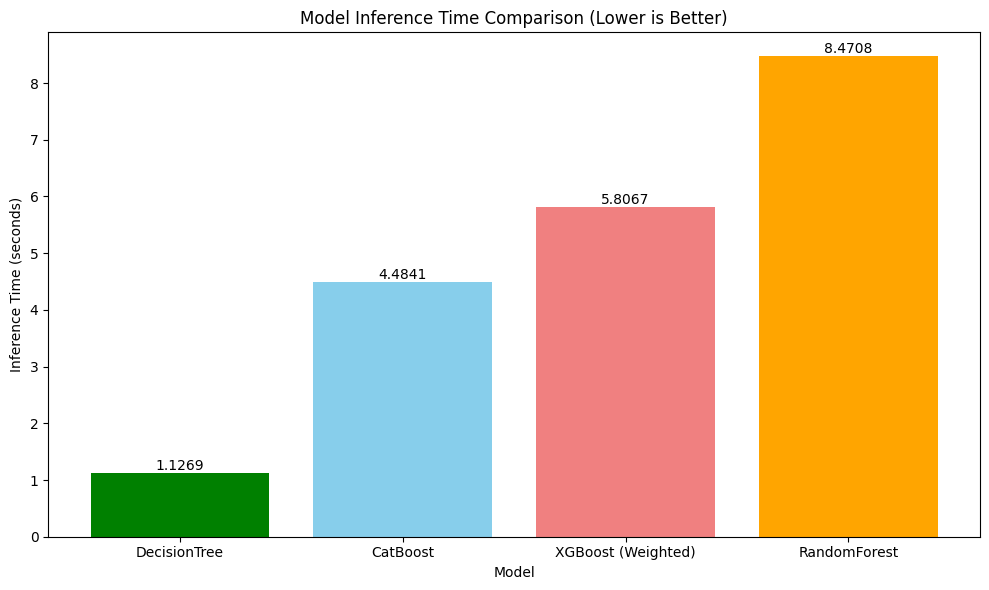

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data provided by the user (Model: Time in seconds)
data = {
    'Model': ['RandomForest', 'CatBoost', 'DecisionTree', 'XGBoost (Weighted)'],
    'Inference Time (s)': [8.4708, 4.4841, 1.1269, 5.8067]
}
df = pd.DataFrame(data)

# Sort the data for better visualization (fastest to slowest prediction time)
df_sorted = df.sort_values(by='Inference Time (s)', ascending=True).reset_index(drop=True)

plt.figure(figsize=(10, 6))

# Plot the bar chart
bars = plt.bar(df_sorted['Model'], df_sorted['Inference Time (s)'], 
               color=['green', 'skyblue', 'lightcoral', 'orange']) 

plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Model Inference Time Comparison (Lower is Better)')

# --- REMOVED: plt.grid(axis='y', linestyle='--', alpha=0.7) ---

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', ha='center', va='bottom')
    
file_name = "inference_time_bar_chart.png"
plt.savefig(file_name, dpi=300)

plt.tight_layout()
plt.show()

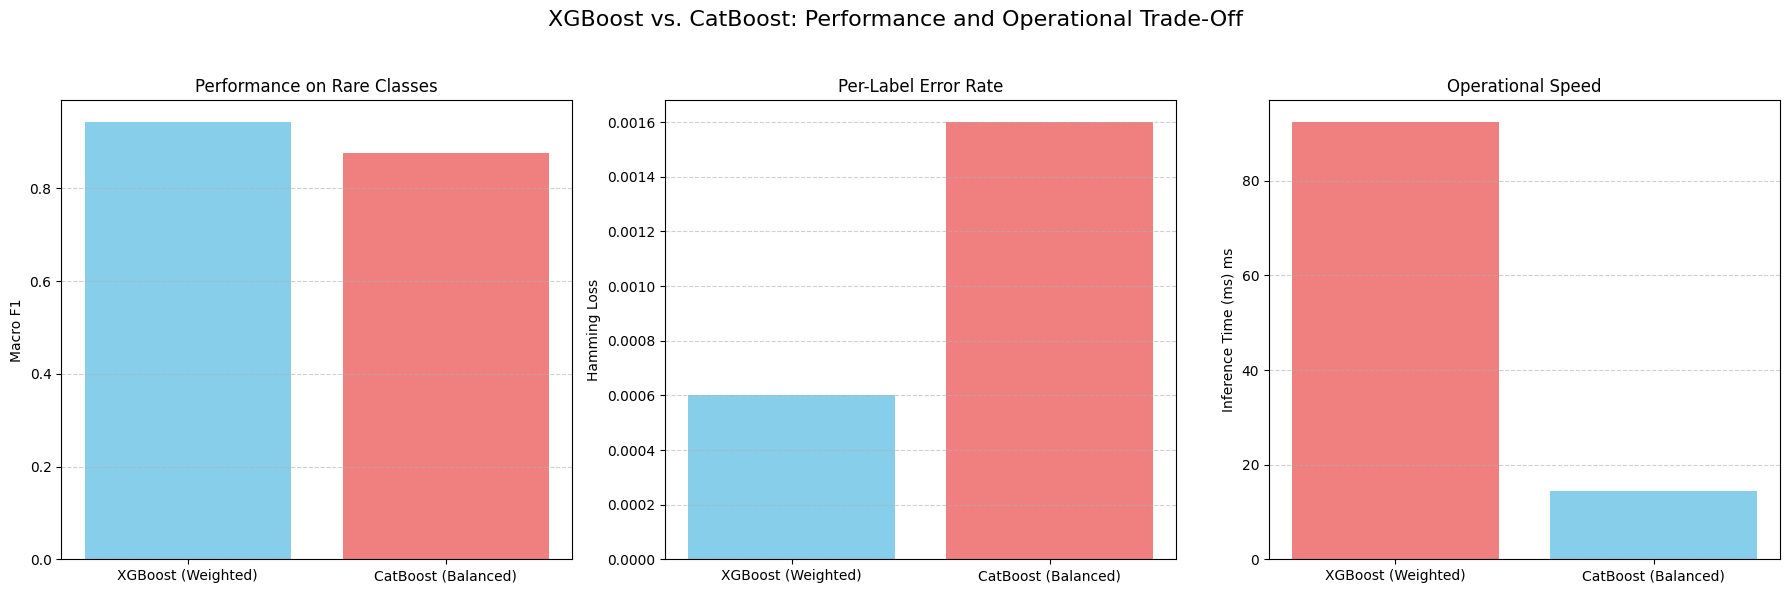

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Data Preparation ---
data = {
    'Model': ['XGBoost (Weighted)', 'CatBoost (Balanced)'],
    'Macro F1': [0.9430, 0.8774],
    'Hamming Loss': [0.0006, 0.0016],
    'Inference Time (ms)': [92.3890, 14.3510]
}
df = pd.DataFrame(data).set_index('Model')

# --- 2. Visualization Function ---
def plot_differentiating_metrics(df):

    metrics = {
        'Macro F1': {'title': 'Performance on Rare Classes', 'unit': '', 'best': 'max'},
        'Hamming Loss': {'title': 'Per-Label Error Rate', 'unit': '', 'best': 'min'},
        'Inference Time (ms)': {'title': 'Operational Speed', 'unit': ' ms', 'best': 'min'}
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('XGBoost vs. CatBoost: Performance and Operational Trade-Off', fontsize=16)

    for i, (metric, params) in enumerate(metrics.items()):
        ax = axes[i]
        df_plot = df[metric]

        # Determine colors and best model
        colors = ['skyblue', 'lightcoral']
        if (params['best'] == 'max' and df_plot.idxmax() == 'CatBoost (Balanced)') or \
           (params['best'] == 'min' and df_plot.idxmin() == 'CatBoost (Balanced)'):
            # Swap colors if CatBoost is the winner for clarity
            colors.reverse()

        bars = ax.bar(df_plot.index, df_plot.values, color=colors)

        ax.set_title(params['title'], fontsize=12)
        ax.set_ylabel(metric + params['unit'])
        ax.tick_params(axis='x', rotation=0)
        ax.grid(axis='y', linestyle='--', alpha=0.6)


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_differentiating_metrics(df)


--- Generating LIME Explanation for Sample 0 (Label: AMCREST WiFi Camera) ---

Top 10 features contributing to the prediction:
[('-0.33 < 19 <= -0.16', 0.008930485416884525), ('-0.67 < 81 <= 1.02', -0.007661960189868435), ('79 > -0.11', 0.006513427733804427), ('-0.46 < 106 <= -0.07', -0.005950722482456239), ('-0.42 < 102 <= 0.05', -0.005444294524809979), ('83 > -0.26', 0.005071846242604041), ('2 <= -0.50', -0.004936316544245506), ('43 > -0.14', 0.004319067837892454), ('-0.56 < 99 <= 0.70', 0.003933426261665402), ('20 > -0.15', -0.003730348169012199)]

LIME visualization saved to: lime_explanation_AMCREST_WiFi_Camera.png


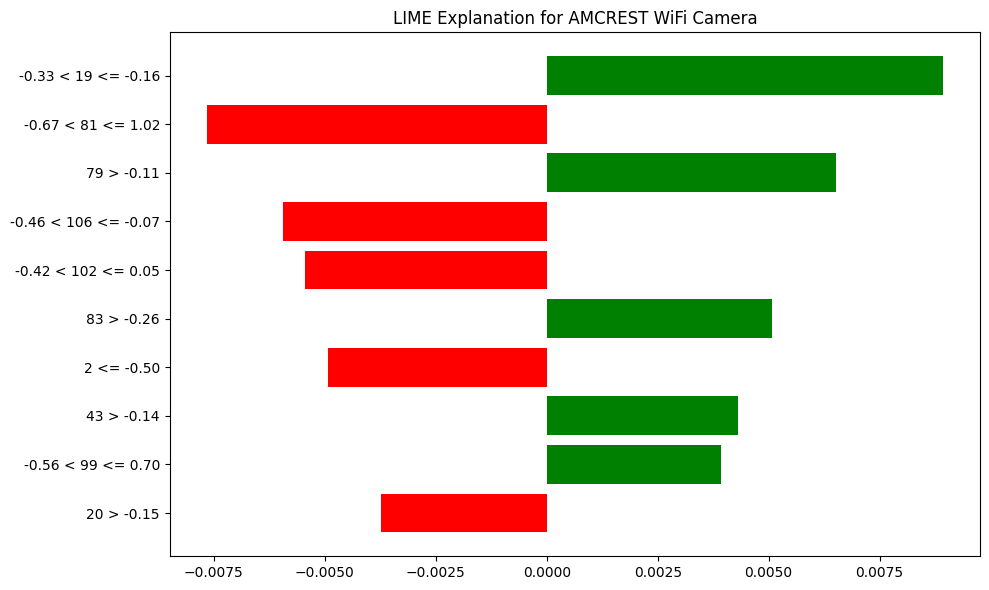

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

X_train_RFE_np = X_RFE.values
X_test_RFE_np = X_test_RFE.values

# --- LIME CONFIGURATION ---
EXPLAIN_SAMPLE_INDEX = 0
EXPLAIN_LABEL_INDEX = 0

# Get the specific sample to explain
sample_to_explain = X_test_RFE_np[EXPLAIN_SAMPLE_INDEX]
target_feature_names = X_RFE.columns.tolist()

# LIME requires a function that takes a NumPy array of data and returns

def predict_proba_for_lime(data):
    """Predicts the probability for the positive class (1) for ONLY the target label 
    (EXPLAIN_LABEL_INDEX) using the correct fitted estimator"""

    # --- FIX IS HERE ---
    # The individual estimators are stored in the .estimators_ attribute.
    # multi_model_dt is the MultiOutputClassifier.
    estimator_for_label = multi_model_dt.estimators_[EXPLAIN_LABEL_INDEX]
    # ------------------

    # Predict probabilities for the input data (which includes the neighbors LIME creates)
    proba = estimator_for_label.predict_proba(data)

    return proba


# LIME Explainer
explainer = LimeTabularExplainer(
    training_data=X_train_RFE_np,
    feature_names=target_feature_names,
    class_names=['Label_0', 'Label_1'],  # The classes for the single binary prediction
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

#Generate the Explanation
print(f"\n--- Generating LIME Explanation for Sample {EXPLAIN_SAMPLE_INDEX} (Label: {multilabel_class_names[EXPLAIN_LABEL_INDEX]}) ---")

# Run the explanation
explanation = explainer.explain_instance(
    data_row=sample_to_explain,
    predict_fn=predict_proba_for_lime,
    num_features=10  # Show the top 10 most influential features
)

#Display the Explanation

# Print the most important features and their weights
print("\nTop 10 features contributing to the prediction:")
print(explanation.as_list())

fig = explanation.as_pyplot_figure(label=1)
fig.set_size_inches(10, 6)

# 3. Add Title and Save
plt.title(f'LIME Explanation for {multilabel_class_names[EXPLAIN_LABEL_INDEX]}')
plt.tight_layout()

# Save the plot
file_name = f"lime_explanation_{multilabel_class_names[EXPLAIN_LABEL_INDEX].replace(' ', '_')}.png"
plt.savefig(file_name, dpi=300)
print(f"\nLIME visualization saved to: {file_name}")

# Show the plot
plt.show()

--- 1. Global Explanation: Mean Feature Importance ---
Global Importance plot saved to: XAI_DT_Global_Importance.png


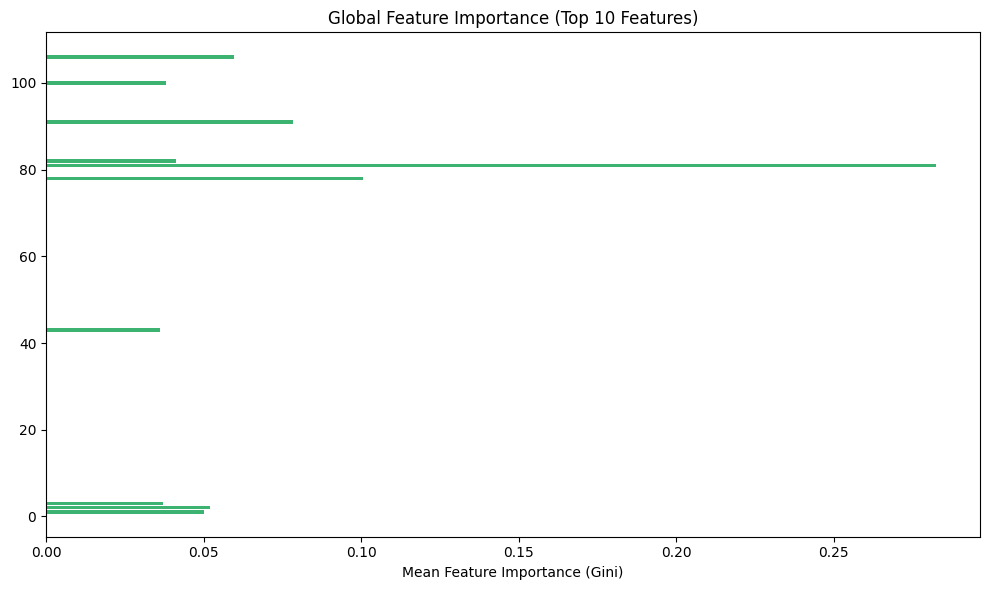


--- 2. Local Explanation: LIME ---
Generating LIME Explanation for Sample 0 (Label: AMCREST WiFi Camera)
LIME visualization saved to: XAI_DT_LIME_AMCREST_WiFi_Camera.png


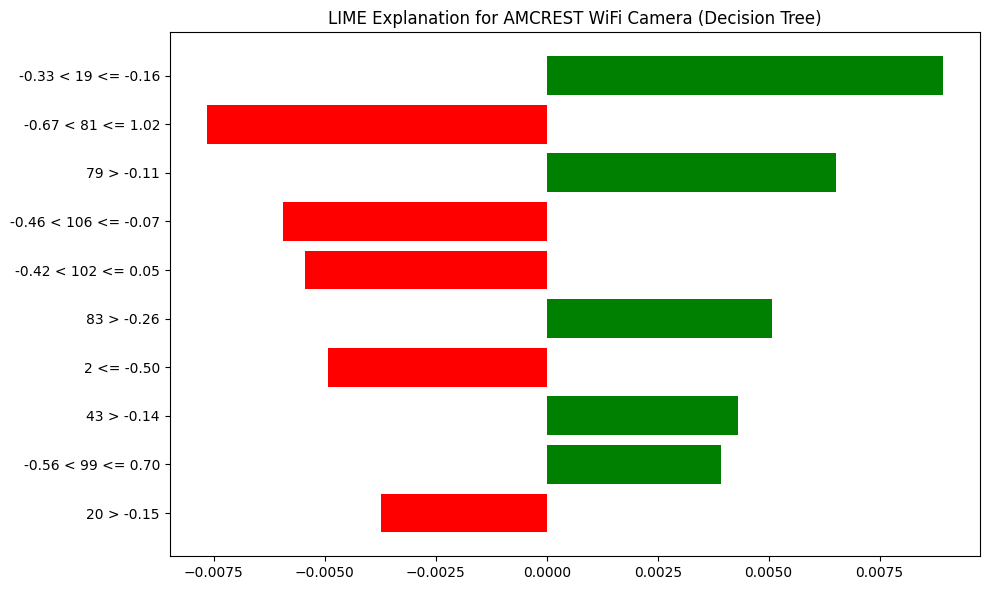

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from lime.lime_tabular import LimeTabularExplainer # Ensure: pip install lime


EXPLAIN_SAMPLE_INDEX = 0  
EXPLAIN_LABEL_INDEX = 0   

# =========================================================================
# 2. GLOBAL EXPLANATION: MEAN FEATURE IMPORTANCE
# =========================================================================

print("--- 1. Global Explanation: Mean Feature Importance ---")

def calculate_mean_feature_importance(multi_model):
    """Calculates the average feature importance across all 61 Decision Tree estimators."""
    
    # Extract feature importances from all estimators
    all_importances = [
        estimator.feature_importances_ 
        for estimator in multi_model.estimators_
    ]
    
    # Calculate the mean importance vector
    mean_importances = np.mean(all_importances, axis=0)
    return mean_importances

# Calculate and store the mean importances
mean_importances = calculate_mean_feature_importance(multi_model_dt)

# Create a DataFrame for easy sorting and plotting
importance_df = pd.DataFrame({
    'Feature': X_RFE.columns,
    'Importance': mean_importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 globally most important features
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(
    importance_df['Feature'][:top_n][::-1], 
    importance_df['Importance'][:top_n][::-1], 
    color='#3cb371' # Medium Sea Green
)
plt.xlabel('Mean Feature Importance (Gini)')
plt.title(f'Global Feature Importance (Top {top_n} Features)')
plt.tight_layout()

file_name_global = "XAI_DT_Global_Importance.png"
plt.savefig(file_name_global, dpi=300)
print(f"Global Importance plot saved to: {file_name_global}")
plt.show()

# =========================================================================
# 3. LOCAL EXPLANATION: LIME SETUP AND EXECUTION
# =========================================================================

print("\n--- 2. Local Explanation: LIME ---")

# Access the individual estimators list from the fitted wrapper
fitted_dt_estimators = multi_model_dt.estimators_
sample_to_explain = X_test_RFE_np[EXPLAIN_SAMPLE_INDEX]
target_feature_names = X_RFE.columns.tolist()

def predict_proba_for_lime(data):
    """Predicts probability for the positive class (1) for the target label."""
    
    # Access the specific estimator using the .estimators_ attribute (CRITICAL)
    estimator_for_label = fitted_dt_estimators[EXPLAIN_LABEL_INDEX]
    proba = estimator_for_label.predict_proba(data)
    return proba


# LIME Explainer
explainer = LimeTabularExplainer(
    training_data=X_RFE.values, # Use the training data's NumPy array
    feature_names=target_feature_names,
    class_names=['Label_0', 'Label_1'], 
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# Generate the Explanation
print(f"Generating LIME Explanation for Sample {EXPLAIN_SAMPLE_INDEX} (Label: {multilabel_class_names[EXPLAIN_LABEL_INDEX]})")

explanation = explainer.explain_instance(
    data_row=sample_to_explain,
    predict_fn=predict_proba_for_lime,
    num_features=10
)

# Display and Save Plot
fig = explanation.as_pyplot_figure(label=1)
fig.set_size_inches(10, 6)
plt.title(f'LIME Explanation for {multilabel_class_names[EXPLAIN_LABEL_INDEX]} (Decision Tree)')
plt.tight_layout()

file_name_local = f"XAI_DT_LIME_{multilabel_class_names[EXPLAIN_LABEL_INDEX].replace(' ', '_')}.png"
plt.savefig(file_name_local, dpi=300)
print(f"LIME visualization saved to: {file_name_local}")
plt.show()